In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from urllib.parse import urlparse
from sklearn import preprocessing
import tldextract
%matplotlib inline
import random
import gc
from sklearn.tree import DecisionTreeClassifier
import os
import random
import lightgbm as lgb
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D

In [ ]:
#setting a random seed value
seed_value=1234

os.environ['PYTHONHASHSEED']=str(seed_value)

random.seed(seed_value)



In [66]:
df=pd.read_csv("/Users/abhinavshinow/Documents/GitHub/Mal_URL/Data/mal_1.csv")
df2=pd.read_csv("/Users/abhinavshinow/Documents/GitHub/Mal_URL/Data/mal_2.csv")
df3=pd.read_csv("/Users/abhinavshinow/Documents/GitHub/Mal_URL/Data/mal_3.csv")

In [67]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [68]:
df2.head()

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0


In [69]:
df3.head()

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [71]:
df.describe()

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [72]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  450176 non-null  int64 
 1   url         450176 non-null  object
 2   label       450176 non-null  object
 3   result      450176 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 13.7+ MB


In [73]:
df2.describe()

,Unnamed: 0,result
count,450176.000000,450176.000000
mean,225087.500000,0.231994
std,129954.761728,0.422105
min,0.000000,0.000000
25%,112543.750000,0.000000
50%,225087.500000,0.000000
75%,337631.250000,0.000000
max,450175.000000,1.000000


In [74]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420464 entries, 0 to 420463
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     420464 non-null  object
 1   label   420464 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


In [75]:
df3.describe()

,url,label
count,420464,420464
unique,411247,2
top,d11m2p9mpffp32.cloudfront.net/main/web_zt.exe,good
freq,27,344821


Preprocessing the data

In [76]:
df['type']=df['type'].replace({'phishing':1,'benign':0,'defacement':1,'malware':1})

In [77]:
df2.drop(df2.columns[df2.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df2.drop('label',axis = 1, inplace = True)
df2=df2.rename(columns={'result': 'type'})

In [78]:
df3=df3.rename(columns={'label': 'type'})
df3['type']=df3['type'].replace({'bad':1,'good':0})

In [79]:
df=df.append(df2)
df=df.append(df3)

In [80]:
df.drop_duplicates(keep='first',inplace=True)

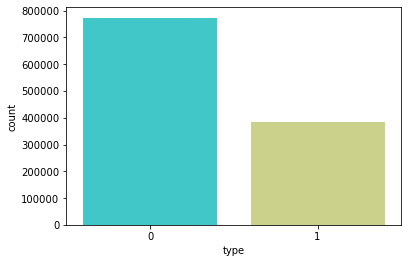

In [81]:
sns.countplot(x='type',data=df, palette='rainbow')
plt.show()

In [82]:
#cleaner method
def getTokens(input):
    tokensBySlash = str(input.encode('utf-8')).split('/')
    allTokens=[]
    for i in tokensBySlash:
        tokens = str(i).split('-')
        tokensByDot = []
        for j in range(0,len(tokens)):
            tempTokens = str(tokens[j]).split('.')
            tokentsByDot = tokensByDot + tempTokens
        allTokens = allTokens + tokens + tokensByDot
    allTokens = list(set(allTokens))
    #if 'com' in allTokens:
        #allTokens.remove('com')
    return allTokens

In [83]:
#Feature Extraction methods

#returns the length of the url
def http(s):
    return s.count('http')

#returns the count of http in the url
def https(s):
    return s.count('https')

#returns the count of www in the url
def www(s):
    return s.count('www')

#returns the count of digits in the url
def digit(s):
    return sum(i.isnumeric() for i in s)

#returns the count of alphabets in the url
def alpha(s):
    return sum(i.isalpha() for i in s)

#returns the count of special character's in the url
def spec_char(s):
    return sum((not(i.isalpha()) and not(i.isnumeric())) for i in s)

#returns the count of / in the url
def spec_char_1(s):
    return s.count('/')

#returns the count of ! in the url
def spec_char_2(s):
    return s.count('!')

#returns the count of . in the url
def spec_char_3(s):
    return s.count('.')

#returns the count of @ in the url    
def spec_char_4(s):
    return s.count('@')

#returns the count of % in the url
def spec_char_5(s):
    return s.count('%')

#returns the count of ? in the url
def spec_char_6(s):
    return s.count('?')

#returns the count of = in the url
def spec_char_7(s):
    return s.count('=')

#returns the count of + in the url
def spec_char_8(s):
    return s.count('+')

#returns the count of - in the url
def spec_char_9(s):
    return s.count('-')

#returns the count of & in the url
def spec_char_10(s):
    return s.count('&')

def query_length(s):
    return len(urlparse(s).query)

#returns the domain of the url
def dom_suffix(s):
    domains={'com':1,'edu':2,'org':3,'net':4,'onion':5,'in':6}
    s=tldextract.extract(s).suffix
    if s in domains.keys():
        return domains[s]
    else:
        return 0

#returns the length of the domain
def dom_length(s):
    return len(tldextract.extract(s).domain)


#returns the length of the sub_domain
def subdom_length(s):
    return len(tldextract.extract(s).subdomain)

#returns the length of the url path
def path_length(s):
    return len(urlparse(s).path)

#returns 1 if url contains a query
def has_query(s):
    if len(urlparse(s).query)==0:
        return 0
    else:
        return 1

def ip(s):
    has_ip=re.search('(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
    '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
    '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
    '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', s)
    if has_ip:
        return 1
    else:
        return 0

#.php .EXE .html .htm .txt .avi .jar .js
def extension(s):
    #domains={'.htm':1,'.html':2,'.js':3,'.css':4,'.exe':5,}
    if '.htm' in s:
        return 1
    elif '.html' in s:
        return 2
    elif '.js' in s:
        return 3
    elif '.css' in s:
        return 4
    elif '.exe' in s:
        return 5
    elif '.php' in s:
        return 6
    elif '.py' in s:
        return 7
    else:
        return 0
#remove youtube links -- youtube.com/watch--pending

In [ ]:
#Extracting the feautures

df['len']=df['url'].apply(lambda s : len(str(s)))

df['http_count']=df['url'].apply(lambda s : http(s))

df['https_count']=df['url'].apply(lambda s : https(s))

df['www']=df['url'].apply(lambda s : www(s))

df['digit_count']=df['url'].apply(lambda s: digit(s))

df['alpha_count']=df['url'].apply(lambda s: alpha(s))

df['spec_char_count']=df['url'].apply(lambda s: spec_char(s))

df['/']=df['url'].apply(lambda s: spec_char_1(s))

df['!']=df['url'].apply(lambda s: spec_char_2(s))

df['.']=df['url'].apply(lambda s: spec_char_3(s))

df['@']=df['url'].apply(lambda s: spec_char_4(s))

df['%']=df['url'].apply(lambda s: spec_char_5(s))

df['?']=df['url'].apply(lambda s: spec_char_6(s))

df['=']=df['url'].apply(lambda s: spec_char_7(s))

df['+']=df['url'].apply(lambda s: spec_char_8(s))

df['-']=df['url'].apply(lambda s: spec_char_9(s))

df['dom_suffix']=df['url'].apply(lambda s: dom_suffix(s))

df['dom_length']=df['url'].apply(lambda s: dom_length(s))

df['subdom_length']=df['url'].apply(lambda s: subdom_length(s))

df['query']=df['url'].apply(lambda s: has_query(s))

df['extension']=df['url'].apply(lambda s: extension(s))

df['ip']=df['url'].apply(lambda s: ip(s))

df.drop('url',axis = 1, inplace = True)

In [85]:
df = shuffle(df)

In [86]:
df.head()

,type,len,http_count,https_count,www,digit_count,alpha_count,spec_char_count,/,!,...,?,=,+,-,dom_suffix,dom_length,subdom_length,query,extension,ip
78666,0,36,0,0,0,0,31,5,2,0,...,0,0,0,0,3,9,2,0,0,0
246204,0,38,0,0,0,0,33,5,1,0,...,1,1,0,0,1,2,0,1,0,0
559297,0,22,0,0,0,0,18,4,1,0,...,0,0,0,0,0,7,10,0,0,0
83941,0,73,0,0,0,0,63,10,1,0,...,1,1,0,0,1,7,0,1,6,0
235896,0,52,1,1,1,8,33,11,7,0,...,0,0,0,1,1,8,3,0,0,0


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1156638 entries, 78666 to 408402
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype
---  ------           --------------    -----
 0   type             1156638 non-null  int64
 1   len              1156638 non-null  int64
 2   http_count       1156638 non-null  int64
 3   https_count      1156638 non-null  int64
 4   www              1156638 non-null  int64
 5   digit_count      1156638 non-null  int64
 6   alpha_count      1156638 non-null  int64
 7   spec_char_count  1156638 non-null  int64
 8   /                1156638 non-null  int64
 9   !                1156638 non-null  int64
 10  .                1156638 non-null  int64
 11  @                1156638 non-null  int64
 12  %                1156638 non-null  int64
 13  ?                1156638 non-null  int64
 14  =                1156638 non-null  int64
 15  +                1156638 non-null  int64
 16  -                1156638 non-null  int64
 17  dom_s

In [90]:
x=df[['len','http_count','https_count','www','digit_count','alpha_count','spec_char_count','/','!','.','@','%','?','=','+','-','dom_suffix','dom_length','subdom_length','query','extension','ip']]
y=df['type']

In [91]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle='True')

In [92]:
model=LogisticRegression(solver='lbfgs', max_iter=10000)
model.fit(x_train,y_train)

LogisticRegression(max_iter=10000)

In [93]:
model.score(x_test,y_test)

0.8565413611841195

In [94]:
pred=model.predict(x_test)

In [95]:
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[149023   5449]
 [ 27737  49119]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90    154472
           1       0.90      0.64      0.75     76856

    accuracy                           0.86    231328
   macro avg       0.87      0.80      0.82    231328
weighted avg       0.86      0.86      0.85    231328



In [96]:
model_1=DecisionTreeClassifier()
model_1.fit(x_train,y_train)

DecisionTreeClassifier()

In [97]:
model_1.score(x_test,y_test)

0.9547914649329091

In [98]:
pred1=model_1.predict(x_test)

In [99]:
print(confusion_matrix(y_test,pred1))
print(classification_report(y_test,pred1))

[[149881   4591]
 [  5867  70989]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    154472
           1       0.94      0.92      0.93     76856

    accuracy                           0.95    231328
   macro avg       0.95      0.95      0.95    231328
weighted avg       0.95      0.95      0.95    231328



In [101]:
x=['len','http_count','https_count','www','digit_count','alpha_count','spec_char_count','/','!','.','@','%','?','=','+','-','dom_suffix','dom_length','subdom_length','query','extension','ip']
min_max_scaler = preprocessing.MinMaxScaler()
column_names_to_normalize = x
x = df[column_names_to_normalize].values
x_scaled = min_max_scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = df.index)
df[column_names_to_normalize] = df_temp

In [102]:
x=df[['len','http_count','https_count','www','digit_count','alpha_count','spec_char_count','/','!','.','@','%','?','=','+','-','dom_suffix','dom_length','subdom_length','query','extension','ip']]
y=df['type']

In [103]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle='True')

In [104]:
model_2=DecisionTreeClassifier()
model_2.fit(x_train,y_train)

DecisionTreeClassifier()

In [105]:
model_2.score(x_test,y_test)

0.9551502628302669

In [106]:
pred2=model_2.predict(x_test)

In [107]:
print(confusion_matrix(y_test,pred2))
print(classification_report(y_test,pred2))

[[150191   4623]
 [  5752  70762]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    154814
           1       0.94      0.92      0.93     76514

    accuracy                           0.96    231328
   macro avg       0.95      0.95      0.95    231328
weighted avg       0.96      0.96      0.96    231328



In [108]:
df.head()

,type,len,http_count,https_count,www,digit_count,alpha_count,spec_char_count,/,!,...,?,=,+,-,dom_suffix,dom_length,subdom_length,query,extension,ip
78666,0,0.015132,0.0,0.000,0.000000,0.000000,0.014479,0.013441,0.043478,0.0,...,0.000000,0.000000,0.0,0.000000,0.500000,0.059603,0.008696,0.0,0.000000,0.0
246204,0,0.015997,0.0,0.000,0.000000,0.000000,0.015413,0.013441,0.021739,0.0,...,0.006024,0.019608,0.0,0.000000,0.166667,0.013245,0.000000,1.0,0.000000,0.0
559297,0,0.009079,0.0,0.000,0.000000,0.000000,0.008407,0.010753,0.021739,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.046358,0.043478,0.0,0.000000,0.0
83941,0,0.031128,0.0,0.000,0.000000,0.000000,0.029426,0.026882,0.021739,0.0,...,0.006024,0.019608,0.0,0.000000,0.166667,0.046358,0.000000,1.0,0.857143,0.0
235896,0,0.022049,0.1,0.125,0.166667,0.006645,0.015413,0.029570,0.152174,0.0,...,0.000000,0.000000,0.0,0.011494,0.166667,0.052980,0.013043,0.0,0.000000,0.0


In [115]:
model_3=lgb.LGBMClassifier()
model_3.fit(x_train,y_train)

LGBMClassifier()

In [116]:
model_3.score(x_test,y_test)

0.9457048001106654

In [117]:
pred3=model_3.predict(x_test)

In [118]:
print(confusion_matrix(y_test,pred3))
print(classification_report(y_test,pred3))

[[151262   3552]
 [  9008  67506]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96    154814
           1       0.95      0.88      0.91     76514

    accuracy                           0.95    231328
   macro avg       0.95      0.93      0.94    231328
weighted avg       0.95      0.95      0.95    231328



In [122]:
#neural network
nn=Sequential()
nn.add(keras.Input(shape=(22,)))
nn.add(Dense(128, activation='relu'))
nn.add(Dense(64, activation='relu'))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(16, activation='relu'))
nn.add(Dense(8, activation='relu'))
nn.add(Dense(4, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))

In [123]:
nn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [124]:
nn.fit(x_train, y_train, epochs=100,validation_data=(x_test, y_test), batch_size=128)

Epoch 1/100
7229/7229 [==============================] - 55s 7ms/step - loss: 0.2559 - accuracy: 0.9195 - val_loss: 0.1750 - val_accuracy: 0.9321
Epoch 2/100
7229/7229 [==============================] - 55s 8ms/step - loss: 0.1656 - accuracy: 0.9347 - val_loss: 0.1535 - val_accuracy: 0.9387
Epoch 3/100
7229/7229 [==============================] - 49s 7ms/step - loss: 0.1502 - accuracy: 0.9402 - val_loss: 0.1470 - val_accuracy: 0.9421
Epoch 4/100
7229/7229 [==============================] - 50s 7ms/step - loss: 0.1416 - accuracy: 0.9439 - val_loss: 0.1372 - val_accuracy: 0.9452
Epoch 5/100
7229/7229 [==============================] - 50s 7ms/step - loss: 0.1367 - accuracy: 0.9458 - val_loss: 0.1332 - val_accuracy: 0.9474
Epoch 6/100
7229/7229 [==============================] - 49s 7ms/step - loss: 0.1333 - accuracy: 0.9473 - val_loss: 0.1308 - val_accuracy: 0.9480
Epoch 7/100
7229/7229 [==============================] - 51s 7ms/step - loss: 0.1305 - accuracy: 0.9483 - val_loss: 0.1257 -